In [3]:
import pandas as pd
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score
from src.utils import *
from src.MetricLinearRegression import MetricLinearRegression
from src.InstrumentalVariable import InstrumentalVariable
import matplotlib.pyplot as plt

In [4]:
def neg_mean_error(estimator, X, y_true):
    y_true = discretize_metric(y_true[:, 0], estimator.pos_threshold, estimator.neg_threshold)
    y_pred = estimator.predict(X)
    return -mean_absolute_error(y_true, y_pred)

In [5]:
def evaluate_classification_model(model, X, y):
    scores = cross_validate(model, X, y, scoring=neg_mean_error, cv=5, n_jobs=-1)
    print(np.mean(scores['test_score']))

In [6]:
def grid_search(X, y):
    iv_model = InstrumentalVariable()
    grid_nu = np.linspace(0.0001, 0.2, num=20)
    grid_reg = np.logspace(-5, 5, num=20)
    grid_p_value = np.linspace(0, 98, num=20)
    params = {'l2_reg': grid_reg, 'critical_p_value': grid_p_value, 'nu': grid_nu}
    gs = GridSearchCV(iv_model, param_grid=params, scoring=make_scorer(r2_score), cv=10, verbose=1, n_jobs=-1)
    gs.fit(X, y)
    return gs.cv_results_

In [7]:
def evaluate_regression_model(model, X, y):
    scores = cross_validate(model, X, y, scoring=make_scorer(r2_score), cv=10, n_jobs=-1)
    return np.mean(scores['test_score'])

In [8]:
def evaluate_model_with_outliers(model, X, y, nu=0.1, n_splits=5):
    kf = KFold(n_splits=n_splits)
    mse = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        outliers = get_outlier_experiments(np.append(X_train[:,:,0], np.reshape(y_train, (-1, 1)), axis=1), nu=nu)
        mask = np.ones(len(X_train), np.bool)
        mask[outliers] = 0
        model.fit(X_train[mask], y_train[mask])
        
        y_pred = model.predict(X_test)
        mse += mean_squared_error(y_test, y_pred)
    return mse / n_splits


In [9]:
def draw_long_short_plots(short_metrics, long_metrics, outliers=None, l0reg = None):
    for i, short in enumerate(short_metrics.swapaxes(0, 1)):
        inds = None
        if l0reg is not None:
            inds = extract_painted_inds(short, l0reg)
            short = short[inds]
        for j, long in enumerate(long_metrics.swapaxes(0, 1)):
            if inds is not None:
                long = long[inds]
            plt.plot(short[:, 0], long[:, 0], 'b.')
            if outliers is not None:
                outlined_short = short[outliers]
                outlined_long = long[outliers]
                plt.plot(outlined_short[:, 0], outlined_long[:, 0], 'r.')            
            if l0reg is None:
                plt.title('Long term metric dependency on short term metrics without l0 regularization')
            else:
                plt.title('Long term metric dependency on short term metrics with l0 regularization: ' + str(l0reg))
            plt.xlabel('short metric: ' + str(i))
            plt.ylabel('long metric: ' + str(j))
            plt.show()

In [10]:
def calculate_std(model, X, y, n_tests):
    coefs = []
    for _ in range(n_tests):
        model.fit(X, y)
        coefs.append(model.coef)
    coefs = np.array(coefs)
    return np.std(coefs, axis=0)

In [11]:
def evaluate_feature_stability(X, y, n_tests=100):
    n_samples, n_features, _ = X.shape
    feature_positives = np.zeros(n_features)
    feature_negatives = np.zeros(n_features)
    coefs = [[] for _ in range(n_features)]
    for _ in range(n_tests):
        nu = np.random.uniform(0, 0.15)        
        p_value = np.random.uniform(80, 95)
        iv_model = InstrumentalVariable(p_value)
        feature_size = np.random.randint(1, n_features + 1)
        feature_inds = np.random.choice(n_features, feature_size, replace=False)
        feature_inds = sorted(feature_inds)
        
        # outliers = get_outlier_experiments(np.append(X[:,:,0], np.reshape(y, (-1, 1)), axis=1), nu=nu)
        outliers = get_outlier_experiments(
            np.append(X[:,:,0], l_features_p[:, :, 0], axis=1), nu=nu)
        mask = np.ones(len(X), np.bool)
        mask[outliers] = 0
        
        boostrap_inds = np.random.choice(len(X) - len(outliers), len(X) - len(outliers))
        
        iv_model.fit(X[:, feature_inds, :][mask][boostrap_inds], y[mask][boostrap_inds])
        
        for i, ind in enumerate(feature_inds):
            if iv_model.coef[i] > 0:
                feature_positives[ind] += 1
            else:
                feature_negatives[ind] += 1
            coefs[ind].append(iv_model.coef[i])
            
    for i, feature_coefs in enumerate(coefs):
            plt.title('Weights for short_term_' + str(i))
            plt.plot(feature_coefs, np.zeros(len(feature_coefs)), 'b.')
            plt.plot([0.0, 0.0], [-1.0, 1.0], 'r')
            plt.show()
    print(feature_positives)
    print(feature_negatives)
    

In [12]:
dataset_path = '../dataset/feed_top_ab_tests_pool_dataset.csv'

df = pd.read_csv(dataset_path)
data = df.to_numpy()
LONG_TERM_COUNT = 4
long_features_raw = data[:, :LONG_TERM_COUNT * 2]
short_features_raw = data[:, LONG_TERM_COUNT * 2:-1]
l_features_p = zip_with_p_value(long_features_raw)
s_features_p = zip_with_p_value(short_features_raw)

s_features_p[:] = [shift_on_zero_value(short_term_metric) for short_term_metric in s_features_p[:]]
s_features = s_features_p[:, :, 0]

target_feature_p = l_features_p[:, 3, :]
target_feature_p = shift_on_zero_value(target_feature_p)
target_feature = target_feature_p[:, 0]

FileNotFoundError: [Errno 2] File b'../dataset/feed_top_ab_tests_pool_dataset.csv' does not exist: b'../dataset/feed_top_ab_tests_pool_dataset.csv'

In [11]:
# lin_reg = MetricLinearRegression(aa_p_value=50, alpha=10, beta=0, l2_reg=0)
# lin_reg.fit(s_features, target_feature_p)
# print(lin_reg.coef)
# print(calculate_std(lin_reg, s_features, target_feature_p, 10))

In [12]:
# evaluate_model(X, y, aa_p_value=30, alpha=1, beta=1, l2_reg=0)

In [13]:
# x = [0, 100]
# pos_threshold = get_positive_threshold(target_feature_p, 99)
# neg_threshold = get_negative_threshold(target_feature_p, 99)
# y1 = [pos_threshold, pos_threshold]
# y2 = [neg_threshold, neg_threshold]
# plt.plot(x, y1, 'b')
# plt.plot(x, y2, 'b')
# plt.xlabel('p-value')
# plt.ylabel('long_term_1')
# plt.plot(target_feature_p[:, 1], target_feature_p[:, 0], 'r.')
# plt.show()

In [16]:
# results = grid_search(s_features_p, target_feature)

Fitting 10 folds for each of 8000 candidates, totalling 80000 fits
0.020060147712908327
{'critical_p_value': 0.0, 'l2_reg': 0.000379269019073225, 'nu': 0.05270526315789474}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 4492 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 12492 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 23692 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 38092 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 55692 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 76492 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 80000 out of 80000 | elapsed:  2.9min finished


{'mean_fit_time': array([0.01669011, 0.00699596, 0.01199279, ..., 0.00729561, 0.00749605,
        0.00699601]),
 'std_fit_time': array([0.01230611, 0.00214357, 0.01375448, ..., 0.00167523, 0.00224587,
        0.00077414]),
 'mean_score_time': array([0.00329847, 0.00099945, 0.00099974, ..., 0.00079958, 0.00099916,
        0.00099974]),
 'std_score_time': array([6.61539676e-03, 4.52367448e-07, 4.46968440e-04, ...,
        3.99792300e-04, 4.46808221e-04, 5.41582903e-07]),
 'param_critical_p_value': masked_array(data=[0.0, 0.0, 0.0, ..., 98.0, 98.0, 98.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_l2_reg': masked_array(data=[1e-05, 1e-05, 1e-05, ..., 100000.0, 100000.0, 100000.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_nu': masked_array(data=[0.0001, 0.010621052631578948, 0.021142105263157896,
                    ...,

In [27]:
for i in range(4):
    t_f = l_features_p[:, i]
    t_f = shift_on_zero_value(t_f)[:, 0]
    var = np.var(t_f)
    iv_model = InstrumentalVariable(0, l2_reg=0, nu=0.052705)
    r2 = evaluate_regression_model(iv_model, s_features_p, t_f)
    print(var, r2)
    print(-var * (r2 - 1))

0.014066835061645095 0.612780363413453
0.005446954760493112
0.008513519779999862 0.4677408487880241
0.004531398811929094
0.006512342427106056 0.43744281874045565
0.0036635649991897225
0.014790287793947613 -0.03875292311142521
0.015363454679622315


In [17]:
# outliers = get_outlier_experiments(s_features, nu=0.1)
# mask = np.ones(len(s_features), np.bool)
# mask[outliers] = 0
# for p_value in range(20, 99):
#     print(p_value, end=' ')
#     iv_model = InstrumentalVariable(p_value)
#     evaluate_regression_model(iv_model, s_features_p, target_feature)
# iv_model = InstrumentalVariable(99, l2_reg=1)
# iv_model.fit(s_features_p, target_feature)
# evaluate_regression_model(iv_model, s_features_p, target_feature)

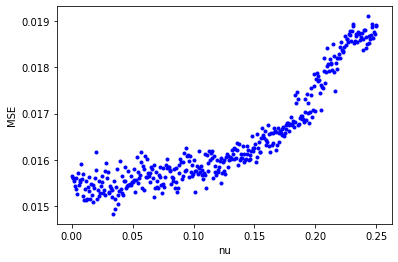

In [36]:
mse = []
nu_l = np.linspace(0.0001, 0.25, num=400)
for nu in nu_l:
    iv_model = InstrumentalVariable(10)
    cur_mse = evaluate_model_with_outliers(iv_model, s_features_p, target_feature, nu=nu, n_splits=10)
    mse.append(cur_mse)
plt.plot(nu_l, mse, 'b.')
plt.xlabel('nu')
plt.ylabel('MSE')
plt.savefig('MSE_nu_dependency.pdf')
plt.show()

In [20]:
# draw_long_short_plots(zipped_X, zipped_y, outliers=outliers)

In [21]:
# iv_model = InstrumentalVariable()
# print(evaluate_model_with_outliers(iv_model, s_features_p, target_feature))
# iv_model.fit(s_features_p, target_feature)
# print(lin_reg.coef)
# print(calculate_std(iv_model, s_features_p, target_feature, 10))

In [22]:
# print(s_features_p[:,:, 0].shape)
# print(target_feature.shape)

In [48]:
for i in range(17):
    print(len(np.argwhere(s_features_p[:, i, 1] > 80).flatten()))
# print(np.append(s_features_p[:,:,0], np.reshape(target_feature, (-1, 1)), axis=1).shape)

185
164
140
216
215
203
173
196
199
171
170
74
221
205
188
148
79


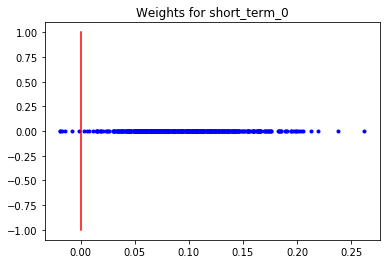

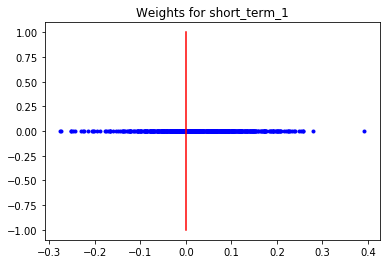

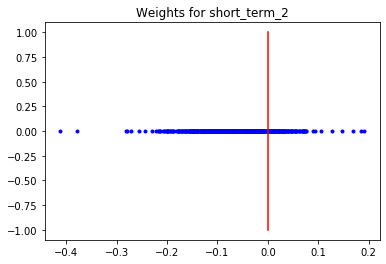

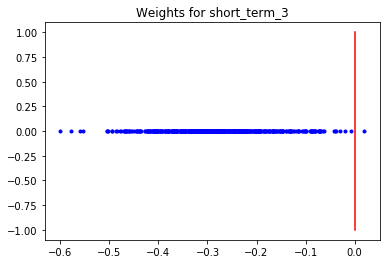

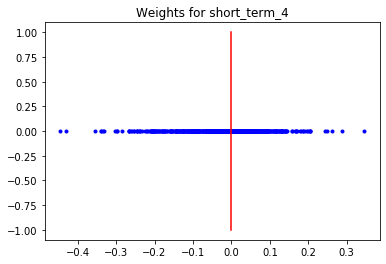

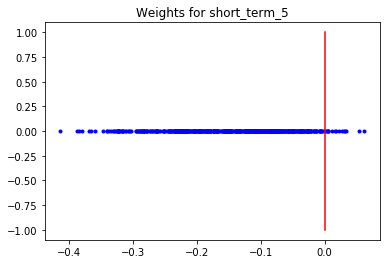

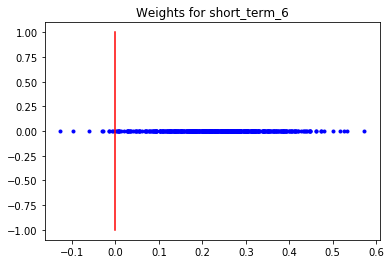

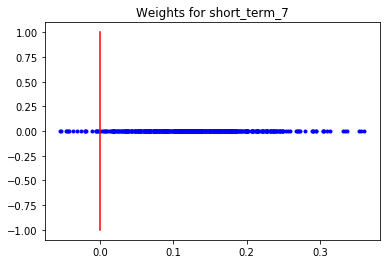

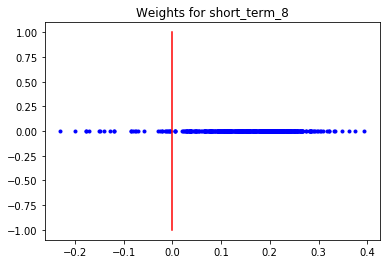

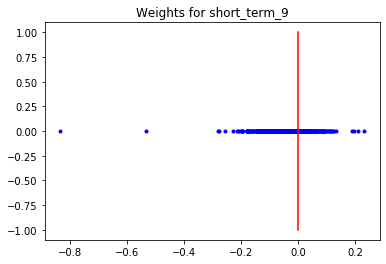

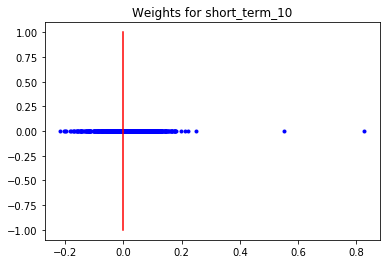

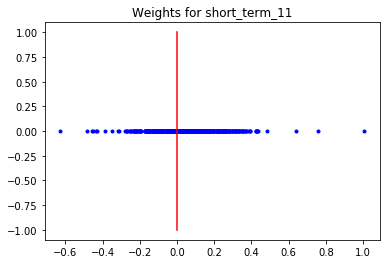

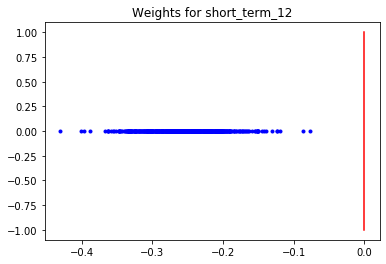

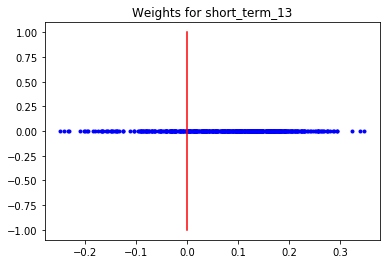

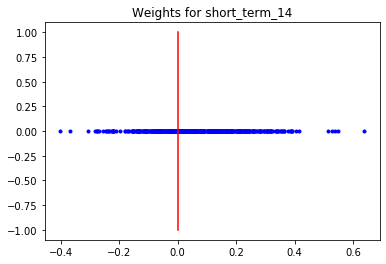

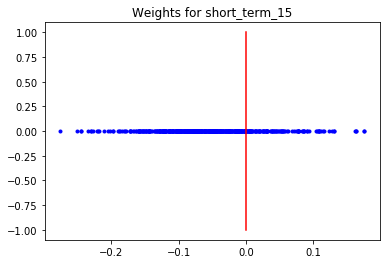

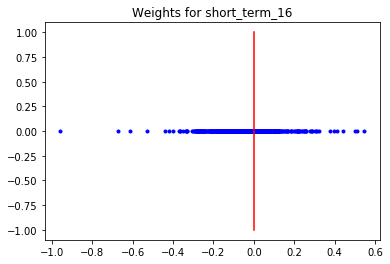

[516. 315.  98.   1. 230.  15. 526. 502. 486. 139. 316. 347.   0. 392.
 342. 106. 211.]
[  6. 206. 447. 526. 315. 525.   9.  18.  29. 399. 205. 199. 531. 114.
 163. 416. 328.]


In [49]:
evaluate_feature_stability(s_features_p, target_feature, n_tests=1000)
